In [1]:
import os

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as gridspec
import dill

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice

sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
from STX3KO_analyses.path_dicts.path_dict_esay import path_dictionary as path_dict
pkl_base_dir = path_dict['pkl_root']

%matplotlib inline

%load_ext autoreload
%autoreload 2

### local functions


In [21]:
# local functions

# modify timeseries for MUXED data (add Nan frames between values to align with lick/speed)

def align_mux(sess):
    for key in list (sess.timeseries.keys()):
        data=sess.timeseries[key]

        if f'channel_0' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,::2] = data # place chan0 values at even index

        elif f'channel_1' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,1::2] = data # place chan1 values at odd index

        else:
            continue 

        sess.timeseries[key] = new_data
    return sess
    
def chan_mask(sess):
    chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
    chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1
    return chan0_nanmask, chan1_nanmask

def reverse_mux_alignment(self, df_key = "channel_0_F_dff"):
    df = self.timeseries[df_key]

    if 'channel_0' in df_key:
        keep = np.arange(df.shape[1]) % 2 ==0 
    elif 'channel_1' in df_key:
        keep = np.arange(df.shape[1]) % 2 == 1
    else: 
        raise ValueError(f"df_key '{df_key}' must include channel")

    unmux = df[:,keep]
    self.timeseries[df_key] = unmux 

def trim_vr(sess):
    print(sess.vr_data.shape[0] - sess.timeseries['channel_0_F'].shape[1])
    if (sess.vr_data.shape[0] - sess.timeseries['channel_0_F'].shape[1]) ==1:
        print('Odd number of VR frames, trimming')
        sess.vr_data.drop(sess.vr_data.tail(1).index,inplace=True) # drop last n rows
    sess.vr_data.shape
    
# create mask for place cells only 
def make_mask(sess): 
    chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
    chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
    chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
    chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']
    
    chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
    chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

    # mask for interneurons
    int_mask1 = u.is_putative_interneuron(sess, ts_key='channel_1_F_dff', method='speed',
                                prct=10, r_thresh=0.3)
    
    int_mask0 = u.is_putative_interneuron(sess, ts_key='channel_0_F_dff', method='speed',
                                prct=10, r_thresh=0.3)
    
    chan1_mask = np.logical_and(chan1_mask, int_mask1)
    chan0_mask = np.logical_and(chan0_mask, int_mask0)

    chan1_left_mask = np.logical_and(chan1_mask_pf_left, int_mask1)
    chan1_right_mask = np.logical_and(chan1_mask_pf_right, int_mask1)
    chan0_left_mask = np.logical_and(chan0_mask_pf_left, int_mask0)
    chan0_right_mask = np.logical_and(chan0_mask_pf_right, int_mask0)
    
    sess.place_cell_info['channel_0_F_dff']['left']['masks'] = chan0_left_mask
    sess.place_cell_info['channel_0_F_dff']['right']['masks'] = chan0_right_mask
    sess.place_cell_info['channel_1_F_dff']['left']['masks'] = chan1_left_mask
    sess.place_cell_info['channel_1_F_dff']['right']['masks'] = chan1_right_mask


def plot_cells(trial_mat, cell_inds=None, n_cols=20):
    '''

    :param ca1:
    :param cell_inds: indices of cells to plot
    :param save_figs:
    :return:
    '''

    if cell_inds is None:
        cell_inds = np.arange(trial_mat.shape[-1])

    n_rows = int(np.ceil(cell_inds.shape[0] / n_cols))
    fig = plt.figure(figsize=[30, 3 * n_rows])
    gs = gridspec(n_rows, n_cols)
    '''
    ES changes: 
    - indexing for pc only indexing error
    '''
    
    # for cell in cell_inds:
    for i, cell in enumerate(cell_inds):
        # col = cell % n_cols
        col = i % n_cols
        # row = int(cell / n_cols)
        row = i //n_cols
        ax = fig.add_subplot(gs[row, col])
        h = ax.imshow(trial_mat[:, :, cell], cmap="magma",aspect = 'auto',interpolation='none')

        if col == 0:
            ax.set_xlabel('pos')
            ax.set_ylabel('trial #')
            if row==0:
                plt.colorbar(h,ax=ax)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    fig.subplots_adjust(hspace=.3)
    return fig

def get_mask(sess):
    chan0_left_mask = sess.place_cell_info['channel_0_F_dff']['left']['masks'] 
    chan0_right_mask = sess.place_cell_info['channel_0_F_dff']['right']['masks'] 
    chan1_left_mask = sess.place_cell_info['channel_1_F_dff']['left']['masks'] 
    chan1_right_mask=sess.place_cell_info['channel_1_F_dff']['right']['masks'] 

    return chan0_left_mask, chan0_right_mask, chan1_left_mask, chan1_right_mask

def update_sess_dict(mouse, f, KO = True):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
    source_folder =  "Z://giocomo/InVivoDA/2P_Data/"
    source_stem = os.path.join(source_folder, mouse, f['date'], f['scene'], scan_str)

    f['mouse']=mouse
    f.update({'scan_file': source_stem + '.sbx',
              'scanheader_file': source_stem + '.mat',
              'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': False,
              'scanner': "NLW",
              'n_channels': 2,
             })
    return f

def save_trial_teleport_inds(sess):
    
    sess.trial_starts = {'channel_0': None, 
                            'channel_1': None
                            }
    sess.trial_ends = {'channel_0': None, 
                            'channel_1': None
                            }

    chan0_start = np.array(sess.trial_start_inds, dtype=np.int64)
    chan0_ends = np.array(sess.teleport_inds, dtype=np.int64)

    chan1_start = np.array(sess.trial_start_inds, dtype=np.int64)
    chan1_ends = np.array(sess.teleport_inds, dtype=np.int64)

    chan0_start[chan0_start % 2 == 1] += 1
    chan0_ends[chan0_ends % 2 == 1] -= 1

    chan1_start[chan1_start % 2 == 0] += 1
    chan1_ends[chan1_ends % 2 == 0] -= 1
    
    sess.trial_starts['channel_0'] = chan0_start//2
    sess.trial_starts['channel_1'] = chan1_start//2
    sess.trial_ends['channel_0']  = chan0_ends//2
    sess.trial_ends['channel_1'] = chan1_ends//2


In [2]:
def update_sess_dict(mouse, f, KO = True):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
    source_folder =  "Z://giocomo/InVivoDA/2P_Data/"
    source_stem = os.path.join(source_folder, mouse, f['date'], f['scene'], scan_str)

    f['mouse']=mouse
    f.update({'scan_file': source_stem + '.sbx',
              'scanheader_file': source_stem + '.mat',
              'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': False,
              'scanner': "NLW",
              'n_channels': 2,
             })
    return f
def save_trial_teleport_inds(sess):
    
    sess.trial_starts = {'channel_0': None, 
                            'channel_1': None
                            }
    sess.trial_ends = {'channel_0': None, 
                            'channel_1': None
                            }

    chan0_start = np.array(sess.trial_start_inds, dtype=np.int64)
    chan0_ends = np.array(sess.teleport_inds, dtype=np.int64)

    chan1_start = np.array(sess.trial_start_inds, dtype=np.int64)
    chan1_ends = np.array(sess.teleport_inds, dtype=np.int64)

    chan0_start[chan0_start % 2 == 1] += 1
    chan0_ends[chan0_ends % 2 == 1] -= 1

    chan1_start[chan1_start % 2 == 0] += 1
    chan1_ends[chan1_ends % 2 == 0] -= 1
    
    sess.trial_starts['channel_0'] = chan0_start//2
    sess.trial_starts['channel_1'] = chan1_start//2
    sess.trial_ends['channel_0']  = chan0_ends//2
    sess.trial_ends['channel_1'] = chan1_ends//2

### function to run place cell calculation

In [3]:
def run_and_save(fdict,comb_frames=0):  
            
    sess = stx.session.YMazeSession(**fdict)
    sess.load_scan_info(sbx_version=3)
    sess.align_VR_to_2P(mux=True)
    sess.load_suite2p_data_ES(which_ts=('F', 'Fneu'), mux = True)
    # sess.load_suite2p_data(which_ts=('F', 'Fneu'))
    sess.get_trial_info()

    # align alternate frames for muxed days
    sess = align_mux(sess)
    chan0_nanmask, chan1_nanmask = chan_mask(sess)

    # if VR is too long, trim by one frame
    trim_vr(sess)


    # calculate dff with alternating frames masked
    sess.neuropil_corrected_dff_ES(Fkey = 'channel_0_F', 
                            Fneukey='channel_0_Fneu', 
                            tau=sess.s2p_ops['channel_0']['tau'],
                               chan_mask = chan0_nanmask,
                            spks_key='channel_0_spks')
    sess.neuropil_corrected_dff_ES(Fkey = 'channel_1_F', 
                                Fneukey='channel_1_Fneu', 
                                tau=sess.s2p_ops['channel_1']['tau'],
                                   chan_mask = chan1_nanmask,
                                spks_key='channel_1_spks')
    
    sess.add_timeseries(licks=sess.vr_data['lick']._values)
    sess.add_pos_binned_trial_matrix('licks')
    speed = sess.vr_data['dz']._values*sess.scan_info['frame_rate']
    sess.add_timeseries(speed=sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix('speed')
    
    fig,ax = plt.subplots()
    ax.plot(speed[:5000])
    
    # speed filtered dff
    ## change to dff NOT spks
    spks = np.copy(sess.timeseries['channel_0_F_dff'])
    sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
    spks[:,speed<2]=np.nan
    sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')
    spks = np.copy(sess.timeseries['channel_1_F_dff'])
    spks[:,speed<2]=np.nan
    sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')

    # speed filtered spks
    spks = np.copy(sess.timeseries['channel_0_spks'])
    sess.add_timeseries(channel_0_spks_speed_filt=spks)
    spks[:,speed<2]=np.nan
    sess.add_pos_binned_trial_matrix('channel_0_spks_speed_filt')
    spks = np.copy(sess.timeseries['channel_1_spks'])
    spks[:,speed<2]=np.nan
    sess.add_timeseries(channel_1_spks_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_1_spks_speed_filt')

    # normalized spks (for activity analysis) 
    sess.add_timeseries(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('channel_0_spks_norm')
    sess.add_timeseries(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('channel_1_spks_norm')


    
    # calculate place cells using dff 
    sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100)
    sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100)

    
    make_mask(sess)
    
    # remove nan values 
    reverse_mux_alignment(sess, df_key = 'channel_0_F_dff')
    reverse_mux_alignment(sess, df_key = 'channel_1_F_dff')
    
    output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/")
    tpu.sess.save_session(sess,output_path)
    return comb_frames+sess.scan_info['max_idx']

### run and save MUXED version

In [70]:
def make_mask(sess, Fkeys = ['F_dff', 'spks','F_dff_speed_filt', 'spks_speed_filt']): 
    print('Making mask for place cells and interneurons')
    for chan in ['channel_0', 'channel_1']:
        for key in Fkeys:
            Fkey = chan + '_' + key
            chan0_mask_pf_left = sess.place_cell_info[Fkey]['left']['masks']
            chan0_mask_pf_right = sess.place_cell_info[Fkey]['right']['masks']
            chan1_mask_pf_left = sess.place_cell_info[Fkey]['left']['masks']
            chan1_mask_pf_right = sess.place_cell_info[Fkey]['right']['masks']
            
            chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
            chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right
        
            # mask for interneurons
            int_mask1 = u.is_putative_interneuron(sess, ts_key=Fkey, method='speed',
                                        prct=10, r_thresh=0.3, mux = True)
            
            int_mask0 = u.is_putative_interneuron(sess, ts_key=Fkey, method='speed',
                                        prct=10, r_thresh=0.3, mux = True)
            
            chan1_mask = np.logical_and(chan1_mask, int_mask1)
            chan0_mask = np.logical_and(chan0_mask, int_mask0)
        
            chan1_left_mask = np.logical_and(chan1_mask_pf_left, int_mask1)
            chan1_right_mask = np.logical_and(chan1_mask_pf_right, int_mask1)
            chan0_left_mask = np.logical_and(chan0_mask_pf_left, int_mask0)
            chan0_right_mask = np.logical_and(chan0_mask_pf_right, int_mask0)
            
            sess.place_cell_info[Fkey]['left']['masks'] = chan0_left_mask
            sess.place_cell_info[Fkey]['right']['masks'] = chan0_right_mask
            sess.place_cell_info[Fkey]['left']['masks'] = chan1_left_mask
            sess.place_cell_info[Fkey]['right']['masks'] = chan1_right_mask

In [85]:
def run_and_save_mux(fdict,comb_frames=0):  
    sess = stx.session.YMazeSession(**fdict)
    sess.load_scan_info(sbx_version=3)
    sess.align_VR_to_2P(mux=True)
    sess.load_suite2p_data_ES(which_ts=('F', 'Fneu'), mux = True)
    # sess.load_suite2p_data(which_ts=('F', 'Fneu'))
    sess.get_trial_info()
    save_trial_teleport_inds(sess)


    # calculate neuropil corrected dff for BOTH channels (two channels, one function?? amazing)

    sess.neuropil_corrected_dff_mux(Fkey_ = 'F',
                                Fneukey_ = 'Fneu',
                                channels = ['channel_0', 'channel_1'],
                                spks_key_ = 'spks')
    # add speed to timeseries

    sess.add_timeseries_mux(channel_0_licks=sess.vr_data_chan0['lick']._values)
    sess.add_pos_binned_trial_matrix_mux('channel_0_licks', channel = 'channel_0')
    channel_0_speed = sess.vr_data_chan0['dz']._values*sess.scan_info['frame_rate']
    sess.add_timeseries_mux(channel_0_speed=sess.vr_data_chan0['dz']._values)
    sess.add_pos_binned_trial_matrix_mux('channel_0_speed', channel = 'channel_0')
    
    fig,ax = plt.subplots()
    ax.plot(channel_0_speed[:5000])
    
    sess.add_timeseries_mux(channel_1_licks=sess.vr_data_chan1['lick']._values)
    sess.add_pos_binned_trial_matrix_mux('channel_1_licks', channel = 'channel_1')
    channel_1_speed = sess.vr_data_chan1['dz']._values*sess.scan_info['frame_rate']
    sess.add_timeseries_mux(channel_1_speed=sess.vr_data_chan1['dz']._values)
    sess.add_pos_binned_trial_matrix_mux('channel_1_speed', channel = 'channel_1')
    
    fig,ax = plt.subplots()
    ax.plot(channel_1_speed[:5000])

    # speed filtered dff
    ## change to dff NOT spks
    dff = np.copy(sess.timeseries['channel_0_F_dff'])
    sess.add_timeseries_mux(channel_0_F_dff_speed_filt=dff)
    dff[:,channel_0_speed<2]=np.nan
    sess.add_pos_binned_trial_matrix_mux('channel_0_F_dff_speed_filt', channel = 'channel_0')
    dff = np.copy(sess.timeseries['channel_1_F_dff'])
    dff[:,channel_1_speed<2]=np.nan
    sess.add_timeseries_mux(channel_1_F_dff_speed_filt=dff)
    sess.add_pos_binned_trial_matrix_mux('channel_1_F_dff_speed_filt', channel = 'channel_1')
    
    # speed filtered spks
    spks = np.copy(sess.timeseries['channel_0_spks'])
    sess.add_timeseries_mux(channel_0_spks_speed_filt=spks)
    spks[:,channel_0_speed<2]=np.nan
    sess.add_pos_binned_trial_matrix_mux('channel_0_spks_speed_filt', channel = 'channel_0')
    spks = np.copy(sess.timeseries['channel_1_spks'])
    spks[:,channel_1_speed<2]=np.nan
    sess.add_timeseries_mux(channel_1_spks_speed_filt=spks)
    sess.add_pos_binned_trial_matrix_mux('channel_1_spks_speed_filt', channel = 'channel_1')

    # normalized spks (for activity analysis) 
    sess.add_timeseries_mux(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix_mux('channel_0_spks_norm', pos_key = 't', channel = 'channel_0')
    sess.add_timeseries_mux(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix_mux('channel_1_spks_norm', pos_key = 't', channel = 'channel_1')

    # actually disgusting block of code to calc place cells with different values

    sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100, mux = True)
    sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100, mux = True)
    
    sess.place_cells_calc(Fkey='channel_0_spks', out_key='channel_0_spks', nperms=100, mux = True)
    sess.place_cells_calc(Fkey='channel_1_spks', out_key='channel_1_spks', nperms=100, mux = True)
    
    sess.place_cells_calc(Fkey='channel_0_F_dff_speed_filt', out_key='channel_0_F_dff_speed_filt', nperms=100, mux = True)
    sess.place_cells_calc(Fkey='channel_1_F_dff_speed_filt', out_key='channel_1_F_dff_speed_filt', nperms=100, mux = True)
    
    sess.place_cells_calc(Fkey='channel_0_spks_speed_filt', out_key='channel_0_spks_speed_filt', nperms=100, mux = True)
    sess.place_cells_calc(Fkey='channel_1_spks_speed_filt', out_key='channel_1_spks_speed_filt', nperms=100, mux = True)

    make_mask(sess)

    # save the damn pickle u idiot
    output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/")
    tpu.sess.save_session(sess,output_path)

In [73]:
mouse = 'SparseKO_06'

f = stx.ymaze_sess_deets.SparseKO_sessions[mouse][0]
f_ = update_sess_dict(mouse,f)
sess = stx.session.YMazeSession(**f_)
sess.load_scan_info(sbx_version=3)
sess.align_VR_to_2P(mux=True)
sess.load_suite2p_data_ES(which_ts=('F', 'Fneu'), mux = True)
# sess.load_suite2p_data(which_ts=('F', 'Fneu'))
sess.get_trial_info()
save_trial_teleport_inds(sess)

Fixing teleports
frame rate 31.25
(160176,) ttl times,(76177,) ca2+ frame times
last time: VR 2437.6733750000003, ca2+ 2437.632
frame rate 31.25
(160176,) ttl times,(76177,) ca2+ frame times
last time: VR 2437.6733750000003, ca2+ 2437.632
(38089, 17) (38089, 17)
['Z://giocomo/InVivoDA/2P_Data/SparseKO_06\\26_05_2025\\YMaze_LNovel\\YMaze_LNovel_004_007\\suite2p', 'Z://giocomo/InVivoDA/2P_Data/SparseKO_06\\26_05_2025\\YMaze_LNovel\\YMaze_LNovel_004_007\\chan2/suite2p']
Odd number of VR frames, trimming
1
2
3
4
5


In [74]:
sess.neuropil_corrected_dff_mux(Fkey_ = 'F',
                                Fneukey_ = 'Fneu',
                                channels = ['channel_0', 'channel_1'],
                                spks_key_ = 'spks')

186 4998
5949 10732
11670 16268
17206 22018
22958 27819
28780 38087
186 4998
5948 10732
11669 16268
17206 22018
22957 27819
28779 38087


In [75]:
sess.timeseries.keys()

dict_keys(['channel_0_F', 'channel_0_Fneu', 'channel_1_F', 'channel_1_Fneu', 'channel_0_F_dff', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks'])

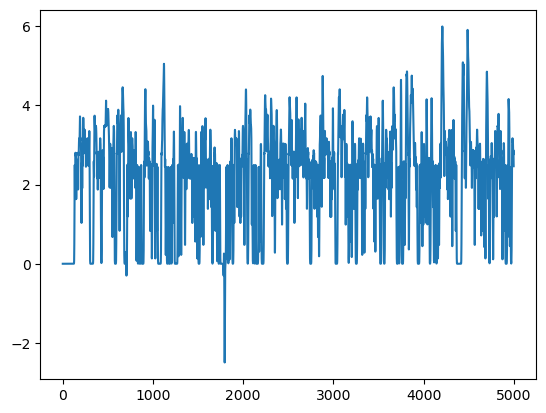

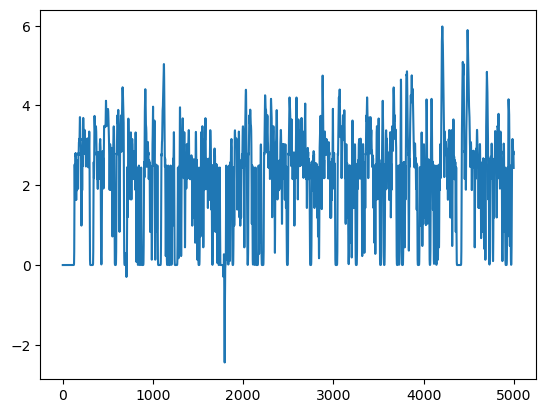

In [76]:
sess.add_timeseries_mux(channel_0_licks=sess.vr_data_chan0['lick']._values)
sess.add_pos_binned_trial_matrix_mux('channel_0_licks', channel = 'channel_0')
channel_0_speed = sess.vr_data_chan0['dz']._values*sess.scan_info['frame_rate']
sess.add_timeseries_mux(channel_0_speed=sess.vr_data_chan0['dz']._values)
sess.add_pos_binned_trial_matrix_mux('channel_0_speed', channel = 'channel_0')

fig,ax = plt.subplots()
ax.plot(channel_0_speed[:5000])

sess.add_timeseries_mux(channel_1_licks=sess.vr_data_chan1['lick']._values)
sess.add_pos_binned_trial_matrix_mux('channel_1_licks', channel = 'channel_1')
channel_1_speed = sess.vr_data_chan1['dz']._values*sess.scan_info['frame_rate']
sess.add_timeseries_mux(channel_1_speed=sess.vr_data_chan1['dz']._values)
sess.add_pos_binned_trial_matrix_mux('channel_1_speed', channel = 'channel_1')

fig,ax = plt.subplots()
ax.plot(channel_1_speed[:5000])



In [77]:

# speed filtered dff
## change to dff NOT spks
dff = np.copy(sess.timeseries['channel_0_F_dff'])
sess.add_timeseries_mux(channel_0_F_dff_speed_filt=dff)
dff[:,channel_0_speed<2]=np.nan
sess.add_pos_binned_trial_matrix_mux('channel_0_F_dff_speed_filt', channel = 'channel_0')
dff = np.copy(sess.timeseries['channel_1_F_dff'])
dff[:,channel_1_speed<2]=np.nan
sess.add_timeseries_mux(channel_1_F_dff_speed_filt=dff)
sess.add_pos_binned_trial_matrix_mux('channel_1_F_dff_speed_filt', channel = 'channel_1')

# speed filtered spks
spks = np.copy(sess.timeseries['channel_0_spks'])
sess.add_timeseries_mux(channel_0_spks_speed_filt=spks)
spks[:,channel_0_speed<2]=np.nan
sess.add_pos_binned_trial_matrix_mux('channel_0_spks_speed_filt', channel = 'channel_0')
spks = np.copy(sess.timeseries['channel_1_spks'])
spks[:,channel_1_speed<2]=np.nan
sess.add_timeseries_mux(channel_1_spks_speed_filt=spks)
sess.add_pos_binned_trial_matrix_mux('channel_1_spks_speed_filt', channel = 'channel_1')

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


In [78]:
# normalized spks (for activity analysis) 
sess.add_timeseries_mux(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
sess.add_pos_binned_trial_matrix_mux('channel_0_spks_norm', pos_key = 't', channel = 'channel_0')
sess.add_timeseries_mux(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
sess.add_pos_binned_trial_matrix_mux('channel_1_spks_norm', pos_key = 't', channel = 'channel_1')

In [81]:
# sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100, mux = True)
# sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100, mux = True)
# sess.place_cells_calc(Fkey='channel_0_spks', out_key='channel_0_spks', nperms=100, mux = True)
# sess.place_cells_calc(Fkey='channel_1_spks', out_key='channel_1_spks', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_0_F_dff_speed_filt', out_key='channel_0_F_dff_speed_filt', nperms=100, mux = True)
sess.place_cells_calc(Fkey='channel_1_F_dff_speed_filt', out_key='channel_1_F_dff_speed_filt', nperms=100, mux = True)
# sess.place_cells_calc(Fkey='channel_0_spks_speed_filt', out_key='channel_0_spks_speed_filt', nperms=100, mux = True)
# sess.place_cells_calc(Fkey='channel_1_spks_speed_filt', out_key='channel_1_spks_speed_filt', nperms=100, mux = True)

perm 0
perm 0
perm 0
perm 0


In [82]:
sess.place_cell_info.keys()

dict_keys(['channel_0_spks', 'channel_1_spks', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt'])

### active code


In [ ]:
mice = ['SparseKO_08', 'SparseKO_10', 'SparseKO_11','SparseKO_13']
for mouse in mice:
    
    for f in stx.ymaze_sess_deets.SparseKO_sessions[mouse][:6]:
    #     print(f)
    
        
        if isinstance(f,dict):
            f_ = update_sess_dict(mouse,f)
            print(f_)
            _ = run_and_save_mux(f_)

    

{'date': '26_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 11, 'novel_arm': -1, 'exp_day': 1, 'mouse': 'SparseKO_08', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\26_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_011.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\26_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_011.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_08\\26_05_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 11, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(142749,) ttl times,(67085,) ca2+ frame times
last time: VR 2146.7311874999996, ca2+ 2146.688
frame rate 31.25
(142749,) ttl times,(67085,) ca2+ frame times
last time: VR 2146.7311874999996, ca2+ 2146.688
(33543, 17) (33543, 17)
['Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\26_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_011\\suite2p', 'Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\26_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_011

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
Making mask for place cells and interneurons
{'date': '27_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 26, 'novel_arm': -1, 'exp_day': 2, 'mouse': 'SparseKO_08', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\27_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_026.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\27_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_026.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_08\\27_05_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 26, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(266389,) ttl times,(76032,) ca2+ frame times
last time: VR 2433.0515625, ca2+ 2432.992
frame rate 31.25
(266389,) ttl times,(76032,) ca2+ frame times
last time: VR 2433.0515625, ca2+ 2432.992
(38016, 17) (38016, 17)
['Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\27

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0


c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:192: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
Making mask for place cells and interneurons
{'date': '28_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'exp_day': 3, 'mouse': 'SparseKO_08', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\28_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_003.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\28_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_003.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_08\\28_05_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 3, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(147216,) ttl times,(67738,) ca2+ frame times
last time: VR 2167.617875, ca2+ 2167.584
frame rate 31.25
(147216,) ttl times,(67738,) ca2+ frame times
last time: VR 2167.617875, ca2+ 2167.584
(33869, 17) (33869, 17)
['Z://giocomo/InVivoDA/2P_Data/SparseKO_08\\28_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_003\\suite2p', 'Z://giocom

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


perm 0
perm 0
perm 0
perm 0
perm 0
perm 0
perm 0


In [60]:
def get_mask(sess, _Fkey):
    Fkey_chan0 = 'channel_0_' + _Fkey
    Fkey_chan1 = 'channel_1_' + _Fkey
    chan0_left_mask = sess.place_cell_info[Fkey_chan0]['left']['masks'] 
    chan0_right_mask = sess.place_cell_info[Fkey_chan0]['right']['masks'] 
    chan1_left_mask = sess.place_cell_info[Fkey_chan1]['left']['masks'] 
    chan1_right_mask=sess.place_cell_info[Fkey_chan1]['right']['masks'] 

    return chan0_left_mask, chan0_right_mask, chan1_left_mask, chan1_right_mask

In [61]:
chan0_left_mask, chan0_right_mask, chan1_left_mask, chan1_right_mask = get_mask(sess, _Fkey = 'spks')

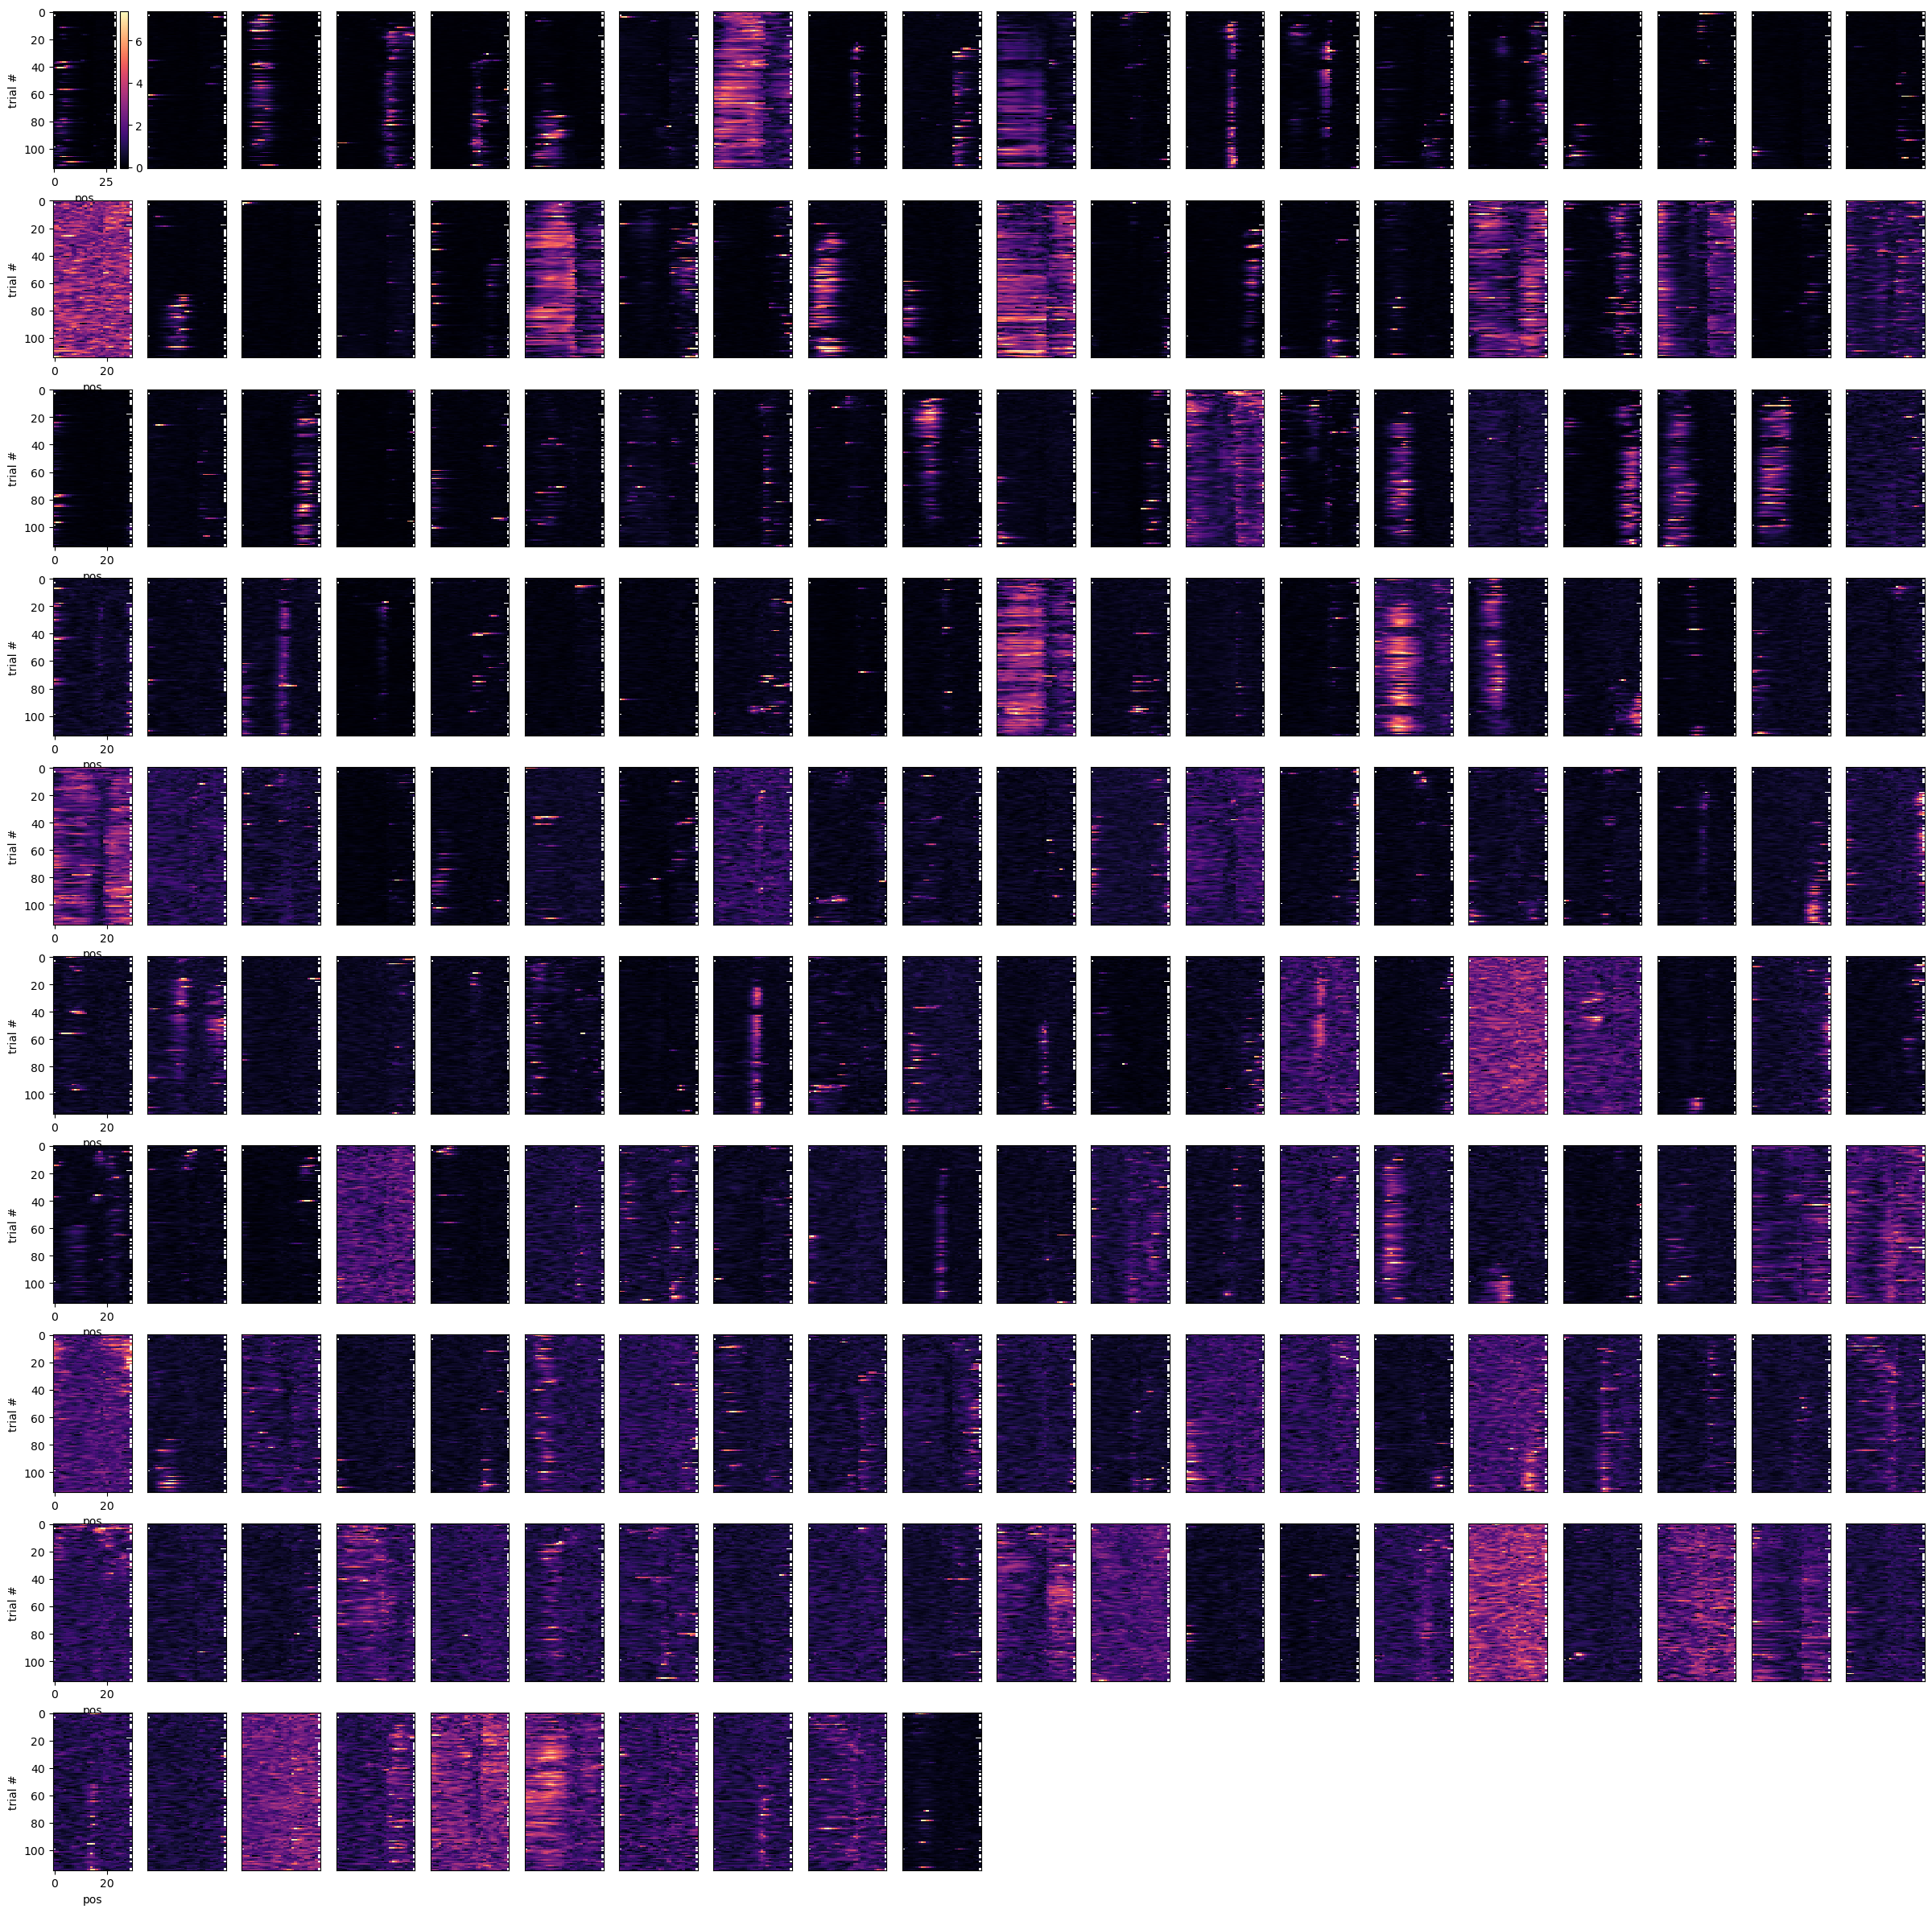

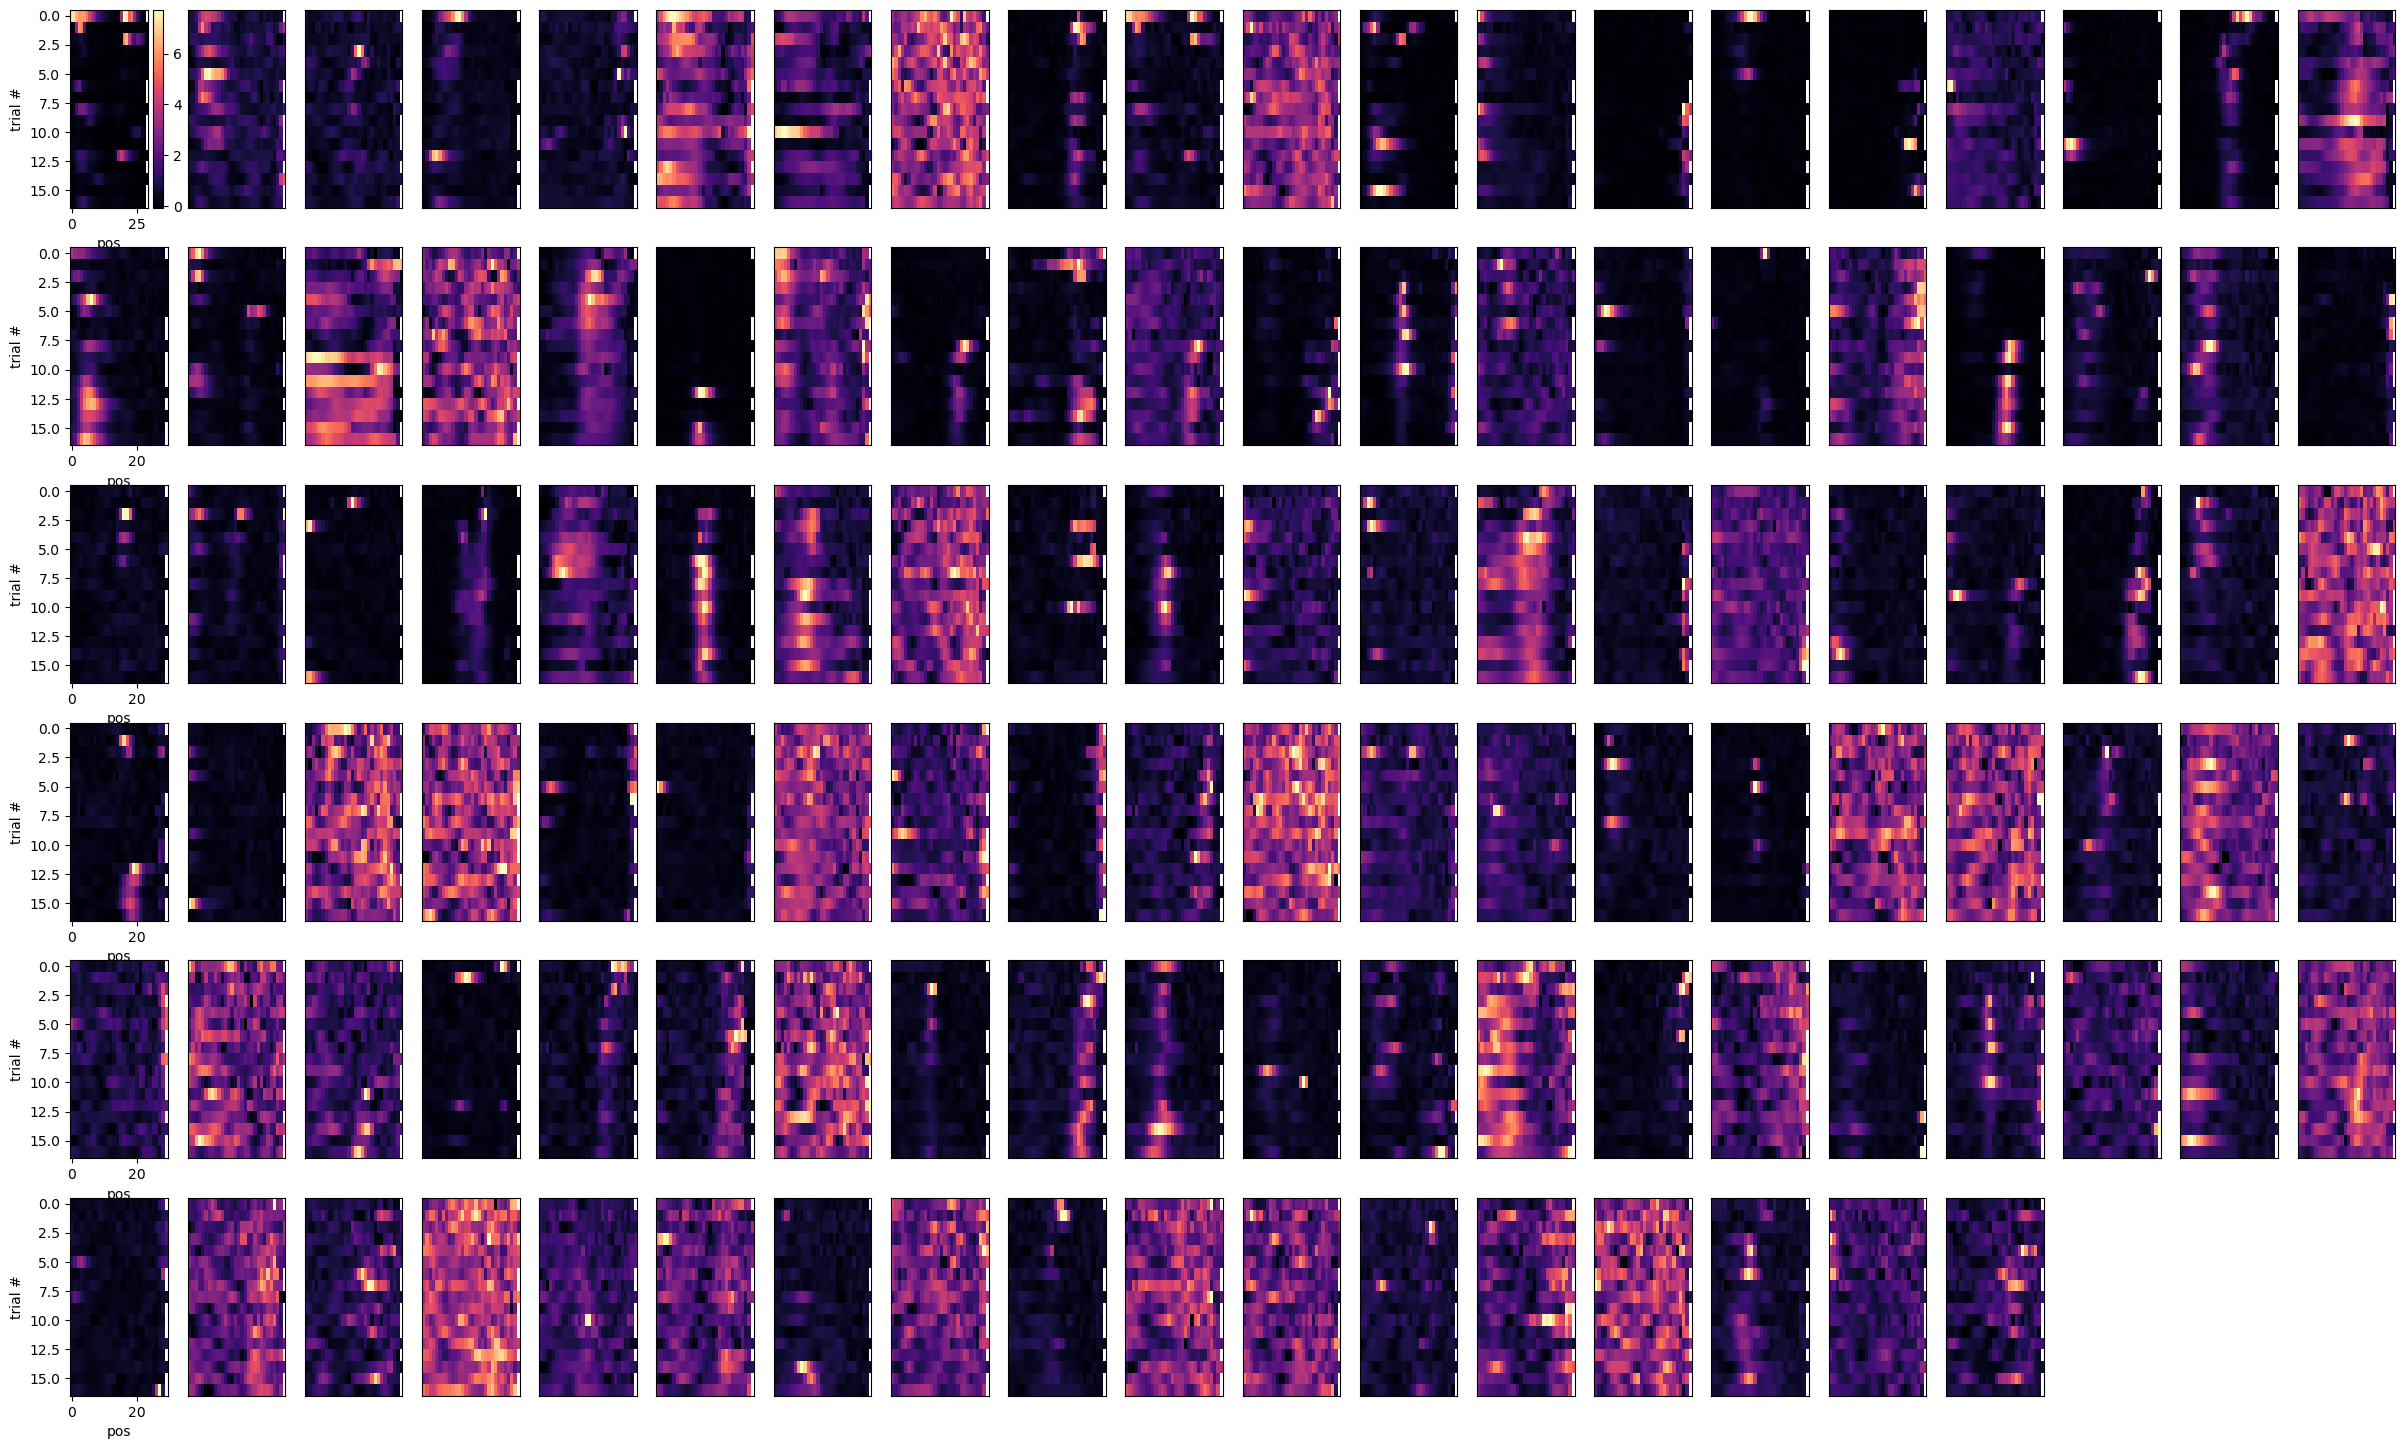

In [62]:
# tmat = sess.trial_matrices['channel_0_F_dff_speed_filt']
tmat = sess.trial_matrices['channel_0_F_dff_speed_filt']

n_cells = tmat.shape[-1]

# plot only place cells using place cell mask
pc_idx = np.where(chan0_left_mask[:n_cells])[0]
fig = plot_cells(tmat[sess.trial_info['LR']==-1*sess.novel_arm,:,:], cell_inds=pc_idx)

# fig = plot_cells(tmat[sess.trial_info['LR']==-1*sess.novel_arm,:,:], cell_inds=np.array([r for r in range(n_cells)]))

pc_idx = np.where(chan0_right_mask[:n_cells])[0]
fig = plot_cells(tmat[sess.trial_info['LR']==1*sess.novel_arm,:,:], cell_inds=pc_idx)
# fig = plot_cells(tmat[sess.trial_info['LR']==1*sess.novel_arm,:,:], cell_inds=np.array([r for r in range(n_cells)]))

In [38]:
tmat.shape

(30, 257)